In [232]:
from pytriqs.gf import *
import pytriqs.utility.mpi as mpi
from ctint_tutorial import CtintSolver
import numpy as np
from pytriqs.plot.mpl_interface import oplot
import matplotlib.pyplot as plt
beta=5.0
omega_0=4
g=1.0
n_iw=1024
half_bandwidth=2.0
n_cycles=20000
U=0.0;
PU=0.0;

In [233]:
alpha=2*g**2/omega_0/half_bandwidth

In [234]:
alpha

0.25

In [235]:
delta=0.01
S = CtintSolver(beta, n_iw) # Initialize the solver
S.G0_iw << SemiCircular(half_bandwidth) # Initialize the Green's function
S.Phonon_iw << 2*omega_0*inverse(iOmega_n*iOmega_n-omega_0**2)
S.solve(U,g,PU,delta, n_cycles, random_name='mt19937')

In [236]:
%reload_ext cpp2py.magic

In [237]:
%%cpp2py -C pytriqs             
#include <triqs/gfs.hpp>
using namespace triqs;
using namespace triqs::gfs;
        
gf<imfreq> MigdalEliashberg(double beta,double g,int n_iw, gf<imfreq> G0,gf<imfreq> D0) {
    clef::placeholder<0> iwn_;
    clef::placeholder<1> iwm_;
    
    int n_iter=1;
    double k=g*g/beta;
    
    auto G = gf<imfreq>{{beta, Fermion, n_iw}, {1, 1}};
    auto Sigma = gf<imfreq>{{beta, Fermion, n_iw}, {1, 1}};
    auto P0=gf<imfreq>{{beta,Boson,n_iw+1},{1,1}};
    auto D=gf<imfreq>{{beta,Boson,n_iw+1},{1,1}};
    
    G(iwn_)=G0(iwn_);
    for(int i=0;i<10;i++){
        P0(iwm_)<< 2*k*sum(G(iwn_)*G(iwm_+iwn_),iwn_=G.mesh());
        D(iwm_) << 1/(1/D0(iwm_) - P0(iwm_));
        Sigma(iwn_)<<-k*sum(G(iwm_+iwn_)*D(iwm_),iwm_=D.mesh());
        G(iwn_) << 1/(1/G0(iwn_) - Sigma(iwn_)); 
    }
    return G;
}

In [238]:
G=MigdalEliashberg(beta,g,n_iw,S.G0_iw['up'],S.Phonon_iw)

In [239]:
G_Migdal = GfImTime(indices = [0], beta = beta , name = 'ME')
G_Free = GfImTime(indices = [0], beta = beta , name = 'Free')
G_QMC = GfImTime(indices = [0], beta = beta , name = 'QMC')

G_Free << InverseFourier(S.G0_iw['up'])
G_Migdal << InverseFourier(G)
G_QMC << InverseFourier(S.G_iw['up'])

Green Function QMC with mesh Imaginary Time Mesh of size 10000, Domain: Matsubara domain with beta = 5, statistic = Fermion and target_rank 2: 

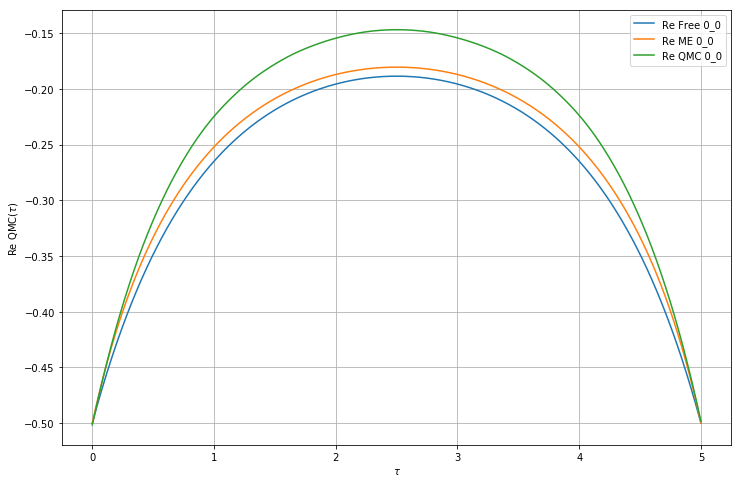

In [240]:
plt.figure(figsize=(12,8))

oplot(G_Free.real)
oplot(G_Migdal.real)
oplot(G_QMC.real)
plt.grid()
# plt.savefig('GF.png',dpi=600)

In [241]:
S.G_iw.density()

{'down': array([[0.49884204-5.06573848e-10j]]),
 'up': array([[0.49837966-5.15943894e-10j]])}

In [242]:
S.G0_iw.density()

{'down': array([[0.49999997-6.97639416e-11j]]),
 'up': array([[0.49999997-6.97639416e-11j]])}

In [243]:
G.density()

array([[0.49999973-3.72355733e-09j]])